# Modeling

For our evaluation metric, we want to use RMSE. RMSE allows us to view the model's error in terms of the target's unit, making it easier to understand. 

We do intend to use clusters in some of our models, but I'm curious to see how the model performs without the clusters first. When all models have been run, we will compare them to see if the clusters we created improve our models.

For the models we will create for our MVP, the features we will be using are `tax_value`, `age`, `sq_ft`, and the clusters we created.

In [1]:
# imports
import wrangle_stewart_01 as wr
import pandas as pd
# turn off pink warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# wrangle data
train, validate, test = wr.split_data(wr.remove_outliers(wr.wrangle_zillow(0.6, 0.8), ['sq_ft', 'baths', 'beds',
                        'fullbaths', 'tax_value'], 1.5))
# standard scale data
train, validate, test = wr.standard_scale_data(train, validate, test, ['baths', 'beds', 'sq_ft', 'tax_value', 'age'])
train.shape, validate.shape, test.shape

((35820, 19), (15352, 19), (12793, 19))

In [3]:
# preview data
train.head()

,baths,beds,sq_ft,fips,fullbaths,latitude,longitude,rooms,yearbuilt,tax_value,logerror,transactiondate,fips_loc,age,baths_scaled,beds_scaled,sq_ft_scaled,tax_value_scaled,age_scaled
18818,3.0,3.0,1683.0,6037,3.0,33874056.0,-118365638.0,0.0,1986.0,331062.0,-0.009760,2017-03-21,"Los Angeles, CA",36.0,1.247680,0.099184,0.208523,-0.135195,-0.770150
52227,2.0,3.0,1085.0,6037,2.0,34616142.0,-117811587.0,0.0,1987.0,109644.0,-0.023405,2017-06-30,"Los Angeles, CA",35.0,-0.154243,0.099184,-0.821472,-1.143307,-0.814908
25353,3.0,3.0,2030.0,6037,3.0,34135615.0,-118502375.0,0.0,1966.0,127529.0,-0.009772,2017-04-11,"Los Angeles, CA",56.0,1.247680,0.099184,0.806196,-1.061877,0.125017
73264,2.0,3.0,1652.0,6059,2.0,33945258.0,-117942079.0,7.0,1959.0,180075.0,-0.021081,2017-09-01,"Orange, CA",63.0,-0.154243,0.099184,0.155128,-0.822636,0.438326
56877,2.0,3.0,1684.0,6037,2.0,34212322.0,-118214747.0,0.0,1942.0,81966.0,-0.006403,2017-07-14,"Los Angeles, CA",80.0,-0.154243,0.099184,0.210245,-1.269324,1.199217


In [4]:
# view summary stats for target
train.logerror.describe()

count    35820.000000
mean         0.014648
std          0.157703
min         -4.655420
25%         -0.023550
50%          0.005932
75%          0.035647
max          3.394544
Name: logerror, dtype: float64

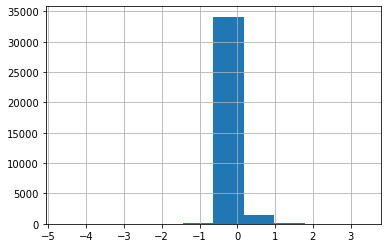

In [5]:
# view logerror distribution
train.logerror.hist();

To establish a baseline, I want to use median rather than mean. Looking at the histogram and summary statistics above, the median seems to be more representative of the data than mean.

In [6]:
# establish baseline
baseline = train.logerror.median()
baseline

0.0059316654231650005

In [7]:
# split data into x and y
scaled_cols = ['tax_value', 'age', 'sq_ft']

x_train = train[scaled_cols]
y_train = train.logerror

x_validate = validate[scaled_cols]
y_validate = validate.logerror

In [8]:
# import eval metric
from sklearn.metrics import mean_squared_error

# evaluate baseline
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

y_train['baseline'] = baseline
y_validate['baseline'] = baseline

rmse_train = mean_squared_error(y_train.logerror, y_train.baseline)**0.5
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.baseline)**0.5

print('Baseline(median `logerror`) RMSE')
print(f'Train: {rmse_train}')
print(f'Validate: {rmse_validate}')

Baseline(median `logerror`) RMSE
Train: 0.15794177457620232
Validate: 0.15517607692395097


In [9]:
# run ols model (without clusters)
from sklearn.linear_model import LinearRegression

# create object
lm = LinearRegression(normalize=True)
# fit model to train
lm.fit(x_train, y_train.logerror)
# train predictions
y_train['ols_pred'] = lm.predict(x_train)
# evaluate model on train
rmse_train_ols = mean_squared_error(y_train.logerror, y_train.ols_pred)**0.5
# validate predictions
y_validate['ols_pred'] = lm.predict(x_validate)
# evaluate model on validate
rmse_validate_ols = mean_squared_error(y_validate.logerror, y_validate.ols_pred)**0.5

# print results
print(f'OLS RMSE Train: {rmse_train_ols}')
print(f'OLS RMSE Validate: {rmse_validate_ols}')

OLS RMSE Train: 0.1575445762277908
OLS RMSE Validate: 0.15475016447694118


In [10]:
# run lassolars without clusters
from sklearn.linear_model import LassoLars

# create object
lars = LassoLars()
# fit model to train
lars.fit(x_train, y_train.logerror)
# make predictions on train
y_train['ll_pred'] = lars.predict(x_train)
# evaluate model on train
rmse_train_ll = mean_squared_error(y_train.logerror, y_train.ll_pred)**0.5
# validate predictions
y_validate['ll_pred'] = lars.predict(x_validate)
# evaluate model on validate
rmse_validate_ll = mean_squared_error(y_validate.logerror, y_validate.ll_pred)**0.5

# print results
print(f'LassoLars RMSE Train: {rmse_train_ll}')
print(f'LassoLars RMSE Validate: {rmse_validate_ll}')

LassoLars RMSE Train: 0.1577010506631275
LassoLars RMSE Validate: 0.15488023191149203


In [11]:
# view results as dataframe
rmse = pd.DataFrame({'Linear Regression':[rmse_train_ols, rmse_validate_ols, (rmse_train_ols-rmse_validate_ols)],
                    'LassoLars':[rmse_train_ll, rmse_validate_ll, (rmse_train_ll-rmse_validate_ll)],
                    'Baseline':[rmse_train, rmse_validate, (rmse_train-rmse_validate)]},
                    index=['train', 'validate', 'difference'])
rmse

,Linear Regression,LassoLars,Baseline
train,0.157545,0.157701,0.157942
validate,0.154750,0.154880,0.155176
difference,0.002794,0.002821,0.002766


**Takeaways:**
- Without using any of the clusters we made in exploration, the Polynomial Regression model appears to perform best. 
 - This model has the lowest RMSE for both train and validate, and it has the smallest difference between train/validate RMSE. 
- All of the models created so far in this notebook have beaten the baseline (median logerror) by a very small margin.

In [12]:
# use selectkbest to get top features
from sklearn.feature_selection import SelectKBest, f_regression
# set parameters for f_selector object
f_selector = SelectKBest(f_regression, k=2)
# fit object to data
f_selector.fit(x_train, y_train.logerror)
# get bool mask of features list
f_mask = f_selector.get_support()
# get list of features (True)
f_feature = x_train.iloc[:,f_mask].columns.tolist()
f_feature

['tax_value', 'sq_ft']

In [13]:
X_train, X_validate, X_test, X_train_scaled, X_validate_scaled, X_test_scaled = wr.scale_and_cluster(train, validate, test, ['sq_ft', 'tax_value', 'age'], ['beds', 'baths', 'sq_ft'], 4)

In [14]:
X_train_scaled

,sq_ft,tax_value,age,cluster
0,0.208523,-0.135195,-0.770150,1
1,-0.821472,-1.143307,-0.814908,1
2,0.806196,-1.061877,0.125017,3
3,0.155128,-0.822636,0.438326,1
4,0.210245,-1.269324,1.199217,1
...,...,...,...,...
35815,-0.795636,0.055748,-0.814908,1
35816,-0.375371,2.051688,2.139142,0
35817,-0.523497,-1.433437,0.930667,0
35818,-1.658559,-0.979459,-0.456841,0


In [15]:
import wrangle as w

zillow = w.acquire_zillow()
zillow = zillow[zillow.propertylandusetypeid.isin([261, 262, 263, 264, 266, 268, 273, 276, 279])]
zillow = zillow[(zillow.baths > 0) & (zillow.beds > 0) & (zillow.sq_ft > 300)]
zillow = zillow.dropna(axis = 1, thresh = .5 * len(zillow))
zillow = zillow.dropna(thresh = .5 * len(zillow.columns))
zillow['age'] = 2022 - zillow.yearbuilt
zillow = zillow.drop(columns = ['propertylandusetypeid', 'transactiondate', 'yearbuilt', 'unitcnt']).dropna()   
zillow[['beds', 'sq_ft', 'fullbaths', 'latitude', 'longitude']] = zillow[['beds', 'sq_ft', 'fullbaths', 'latitude', 'longitude']].astype('int')
for col in zillow[['baths', 'beds', 'sq_ft', 'fullbaths', 'tax_value']]:    
    q1, q3 = zillow[col].quantile([.25, .75])
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
zillow = zillow[(zillow[col]>lower)&(zillow[col]<upper)]
zillow

,baths,beds,sq_ft,fips,fullbaths,latitude,longitude,rooms,tax_value,logerror,age
0,3.5,4,3100,6059.0,3,33634931,-117869207,0.0,1023282.0,0.025595,24.0
1,1.0,2,1465,6111.0,1,34449266,-119281531,5.0,464000.0,0.055619,55.0
2,2.0,3,1243,6059.0,2,33886168,-117823170,6.0,564778.0,0.005383,60.0
3,3.0,4,2376,6037.0,3,34245180,-118240722,0.0,145143.0,-0.103410,52.0
4,3.0,3,1312,6037.0,3,34185120,-118414640,0.0,119407.0,0.006940,58.0
...,...,...,...,...,...,...,...,...,...,...,...
77375,3.0,3,1741,6037.0,3,34202400,-118502000,0.0,379000.0,-0.002245,42.0
77376,2.0,2,1286,6037.0,2,34245368,-118282383,0.0,354621.0,0.020615,82.0
77377,2.0,4,1612,6111.0,2,34300140,-118706327,7.0,67205.0,0.013209,58.0
77378,1.0,3,1032,6037.0,1,34040895,-118038169,0.0,49546.0,0.037129,68.0


In [16]:
def scale_and_cluster(train, validate, test, model_vars, cluster_vars, k):
    '''
    This function takes in a list of variables to be modeled on, a list of features to
    cluster by, and a k-value to determine the number of clusters to create.
    It returns train, validate, and test dataframes with a cluster column, as well as scaled versions
    of train, validate, and test with a cluster column.
    '''
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    # define independent variables
    X_train = pd.concat([train[model_vars], train[cluster_vars]], axis=1)
    X_train = X_train.loc[:,~X_train.columns.duplicated()]
    X_validate = pd.concat([validate[model_vars], validate[cluster_vars]], axis=1)
    X_validate = X_validate.loc[:,~X_validate.columns.duplicated()]
    X_test = pd.concat([test[model_vars], test[cluster_vars]], axis=1)
    X_test = X_test.loc[:,~X_test.columns.duplicated()]
    # scale features
    scaler = StandardScaler().fit(X_train)
    X_scaled_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
    X_scaled_validate = pd.DataFrame(scaler.transform(X_validate), columns = X_validate.columns)
    X_scaled_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
    # create kmeans object
    kmeans = KMeans(n_clusters=k, random_state=123)
    # fit object
    kmeans.fit(X_scaled_train[cluster_vars])
    # make predictions
    kmeans.predict(X_scaled_train[cluster_vars])
    # create columns for predictions
    train['cluster'] = kmeans.predict(X_scaled_train[cluster_vars])
    X_scaled_train['cluster'] = kmeans.predict(X_scaled_train[cluster_vars])
    validate['cluster'] = kmeans.predict(X_scaled_validate[cluster_vars])
    X_scaled_validate['cluster'] = kmeans.predict(X_scaled_validate[cluster_vars])
    test['cluster'] = kmeans.predict(X_scaled_test[cluster_vars])
    X_scaled_test['cluster'] = kmeans.predict(X_scaled_test[cluster_vars])
    model_vars.append('cluster')
    X_train = X_scaled_train[model_vars]
    X_validate = X_scaled_validate[model_vars]
    X_test = X_scaled_test[model_vars]
    return X_train, X_validate, X_test

In [17]:
X_train, X_validate, X_test = scale_and_cluster(train, validate, test, ['tax_value', 'age', 'sq_ft'], ['beds', 'baths', 'sq_ft'], 4)

In [18]:
def encode_clusters(X_train, X_validate, X_test):
    '''
This function takes in scaled X_train/validate/test dfs and encodes the cluster column. Dropping the 
original unencoded cluster column.
    '''
    
    #encode cluster column
    dummy_train_df = pd.get_dummies(X_train.cluster, prefix='cluster_')
    dummy_validate_df = pd.get_dummies(X_validate.cluster, prefix='cluster_')
    dummy_test_df = pd.get_dummies(X_test.cluster, prefix='cluster_')
    
    encoded_train = pd.concat([X_train , dummy_train_df], axis = 1)
    encoded_validate = pd.concat([X_validate , dummy_validate_df], axis = 1)
    encoded_test = pd.concat([X_test , dummy_test_df], axis = 1)
    
    X_train_encoded = encoded_train.drop(columns = ['cluster'])
    X_validate_encoded = encoded_validate.drop(columns = ['cluster'])
    X_test_encoded = encoded_test.drop(columns = ['cluster'])
        
    return X_train_encoded, X_validate_encoded, X_test_encoded

In [19]:
X_train, X_validate, X_test = scale_and_cluster(train, validate, test, ['tax_value', 'age', 'sq_ft'], ['beds', 'baths', 'sq_ft'], 4)
X_train, X_validate, X_test = encode_clusters(X_train, X_validate, X_test)
X_train.head()

,tax_value,age,sq_ft,cluster__0,cluster__1,cluster__2,cluster__3
0,-0.135195,-0.770150,0.208523,0,1,0,0
1,-1.143307,-0.814908,-0.821472,0,1,0,0
2,-1.061877,0.125017,0.806196,0,0,0,1
3,-0.822636,0.438326,0.155128,0,1,0,0
4,-1.269324,1.199217,0.210245,0,1,0,0


In [20]:
def model_features(target, X_scaled_train, X_scaled_validate, X_scaled_test, y_train, y_validate, y_test):
#baseline_prediction
    median = y_train[target].median()
    y_train['baseline_pred'] = median
    y_validate['baseline_pred'] = median
   
    rmse_baseline_train = mean_squared_error(y_train[target], y_train.baseline_pred)**(1/2)
    rmse_baseline_validate = mean_squared_error(y_train[target], y_train.baseline_pred)**(1/2)
   
    print('Baseline RSME')
    print(f'rmse_baseline_train: {rmse_baseline_train}')
    print(f'rmse_baseline_validate: {rmse_baseline_validate}')
    print()

# plt.hist(y_train[target], color='blue', alpha=.5, label=f'{target.upper()}')
#    plt.hist(y_train['baseline_pred'], bins=1, color='red', alpha=.5, rwidth=100, label=f'Predicted {target.upper()}')
#    plt.xlabel(f'{target.upper()}')
#    plt.legend()
#    plt.show();
   
   #model01_prediction
    lm = LinearRegression(normalize=True)
    lm.fit(X_scaled_train, y_train[target])
   
    y_train['model01_pred'] = lm.predict(X_scaled_train)
    y_validate['model01_pred'] = lm.predict(X_scaled_validate)
   
    rsme_model01_train = (mean_squared_error(y_train.logerror, y_train['model01_pred']))**(1/2)
    rsme_model01_validate = (mean_squared_error(y_validate.logerror, y_validate['model01_pred']))**(1/2)
   
    print('Model 01 | Linear Reg OLS RMSE')
    print(f'rmse_model01_train: {rsme_model01_train}')
    print(f'rmse_model01_validate: {rsme_model01_validate}')   
    print()
   
   
   #model02_prediction
    lars = LassoLars(alpha=1.0)
    lars.fit(X_scaled_train, y_train[target])
   
    y_train['model02_pred'] = lars.predict(X_scaled_train)
    y_validate['model02_pred'] = lars.predict(X_scaled_validate)
   
    rsme_model02_train = (mean_squared_error(y_train.logerror, y_train['model02_pred']))**(1/2)
    rsme_model02_validate = (mean_squared_error(y_validate.logerror, y_validate['model02_pred']))**(1/2)
   
    print('Model 02 | LassoLars RMSE')
    print(f'rmse_model02_train: {rsme_model02_train}')
    print(f'rmse_model02_validate: {rsme_model02_validate}')   
    print()

In [21]:
model_features('logerror', X_train[['tax_value', 'age', 'sq_ft']], X_validate[['tax_value', 'age', 'sq_ft']], X_test[['tax_value', 'age', 'sq_ft']], pd.DataFrame(train.logerror), pd.DataFrame(validate.logerror), pd.DataFrame(test.logerror))

Baseline RSME
rmse_baseline_train: 0.15794177457620232
rmse_baseline_validate: 0.15794177457620232

Model 01 | Linear Reg OLS RMSE
rmse_model01_train: 0.1575445762277908
rmse_model01_validate: 0.15475016447694118

Model 02 | LassoLars RMSE
rmse_model02_train: 0.1577010506631275
rmse_model02_validate: 0.15488023191149203



In [22]:
model_features('logerror', X_train, X_validate, X_test, pd.DataFrame(train.logerror), pd.DataFrame(validate.logerror), pd.DataFrame(test.logerror))

Baseline RSME
rmse_baseline_train: 0.15794177457620232
rmse_baseline_validate: 0.15794177457620232

Model 01 | Linear Reg OLS RMSE
rmse_model01_train: 0.15753640816475467
rmse_model01_validate: 0.15473984428136414

Model 02 | LassoLars RMSE
rmse_model02_train: 0.1577010506631275
rmse_model02_validate: 0.15488023191149203



In [23]:
# define y
y_train = pd.DataFrame(train.logerror)
y_validate = pd.DataFrame(validate.logerror)
y_test = pd.DataFrame(test.logerror)

# run ols with clusters
# create object
lm = LinearRegression(normalize=True)
# fit model to train
lm.fit(X_train, y_train)
# train predictions
y_train['ols_pred'] = lm.predict(X_train)
# evaluate model on train
rmse_train_ols_cl = mean_squared_error(y_train.logerror, y_train.ols_pred)**0.5
# validate predictions
y_validate['ols_pred'] = lm.predict(X_validate)
# evaluate model on validate
rmse_validate_ols_cl = mean_squared_error(y_validate.logerror, y_validate.ols_pred)**0.5

# print results
print(f'OLS RMSE Train: {rmse_train_ols_cl}')
print(f'OLS RMSE Validate: {rmse_validate_ols_cl}')

OLS RMSE Train: 0.15753640816475467
OLS RMSE Validate: 0.15473984428136414


In [24]:
# run ols without clusters
# create object
lm = LinearRegression(normalize=True)
# fit model to train
lm.fit(X_train[['tax_value', 'age', 'sq_ft']], y_train)
# train predictions
y_train['ols_pred'] = lm.predict(X_train[['tax_value', 'age', 'sq_ft']])
# evaluate model on train
rmse_train_ols = mean_squared_error(y_train.logerror, y_train.ols_pred)**0.5
# validate predictions
y_validate['ols_pred'] = lm.predict(X_validate[['tax_value', 'age', 'sq_ft']])
# evaluate model on validate
rmse_validate_ols = mean_squared_error(y_validate.logerror, y_validate.ols_pred)**0.5

# print results
print(f'OLS RMSE Train: {rmse_train_ols}')
print(f'OLS RMSE Validate: {rmse_validate_ols}')

OLS RMSE Train: 0.1575445762277908
OLS RMSE Validate: 0.15475016447694118


In [25]:
# run lassolars with clusters
from sklearn.linear_model import LassoLars

# create object
lars = LassoLars()
# fit model to train
lars.fit(X_train, y_train.logerror)
# make predictions on train
y_train['ll_pred'] = lars.predict(X_train)
# evaluate model on train
rmse_train_ll_cl = mean_squared_error(y_train.logerror, y_train.ll_pred)**0.5
# validate predictions
y_validate['ll_pred'] = lars.predict(X_validate)
# evaluate model on validate
rmse_validate_ll_cl = mean_squared_error(y_validate.logerror, y_validate.ll_pred)**0.5

# print results
print(f'LassoLars RMSE Train: {rmse_train_ll_cl}')
print(f'LassoLars RMSE Validate: {rmse_validate_ll_cl}')

LassoLars RMSE Train: 0.1577010506631275
LassoLars RMSE Validate: 0.15488023191149203


In [26]:
# run lassolars without clusters
from sklearn.linear_model import LassoLars

# create object
lars = LassoLars()
# fit model to train
lars.fit(X_train[['tax_value', 'age', 'sq_ft']], y_train.logerror)
# make predictions on train
y_train['ll_pred'] = lars.predict(X_train[['tax_value', 'age', 'sq_ft']])
# evaluate model on train
rmse_train_ll = mean_squared_error(y_train.logerror, y_train.ll_pred)**0.5
# validate predictions
y_validate['ll_pred'] = lars.predict(X_validate[['tax_value', 'age', 'sq_ft']])
# evaluate model on validate
rmse_validate_ll = mean_squared_error(y_validate.logerror, y_validate.ll_pred)**0.5

# print results
print(f'LassoLars RMSE Train: {rmse_train_ll}')
print(f'LassoLars RMSE Validate: {rmse_validate_ll}')

LassoLars RMSE Train: 0.1577010506631275
LassoLars RMSE Validate: 0.15488023191149203


In [27]:
# view results as dataframe
rmse = pd.DataFrame({'OLS with Clusters':[rmse_train_ols_cl, rmse_validate_ols_cl, (rmse_train_ols_cl-rmse_validate_ols_cl)],
                     'OLS without Clusters':[rmse_train_ols, rmse_validate_ols, (rmse_train_ols-rmse_validate_ols)],
                     'LassoLars with Clusters':[rmse_train_ll_cl, rmse_validate_ll_cl, (rmse_train_ll_cl-rmse_validate_ll_cl)],
                     'LassoLars without Clusters':[rmse_train_ll, rmse_validate_ll, (rmse_train_ll-rmse_validate_ll)],
                     'Baseline':[rmse_train, rmse_validate, (rmse_train-rmse_validate)]},
                    index=['train', 'validate', 'difference'])
rmse

,OLS with Clusters,OLS without Clusters,LassoLars with Clusters,LassoLars without Clusters,Baseline
train,0.157536,0.157545,0.157701,0.157701,0.157942
validate,0.154740,0.154750,0.154880,0.154880,0.155176
difference,0.002797,0.002794,0.002821,0.002821,0.002766


Based on the results of our models, it appears the OLS models performed best. Of those, 
- both models performed better on validate than on train
- the model with clusters performed better on the train set
- the model without clusters performed better on the validate set
- there was less of a difference between train and validate for the OLS model with clusters

In [28]:
def model_features_df(target, X_scaled_train, X_scaled_validate, X_scaled_test, y_train, y_validate, y_test, model_vars):
#baseline_prediction
    median = y_train[target].median()
    y_train['baseline_pred'] = median
    y_validate['baseline_pred'] = median
   
    rmse_baseline_train = mean_squared_error(y_train[target], y_train.baseline_pred)**(1/2)
    rmse_baseline_validate = mean_squared_error(y_validate[target], y_validate.baseline_pred)**(1/2)

   #model01_prediction
    lm = LinearRegression(normalize=True)
    lm.fit(X_scaled_train, y_train[target])
   
    y_train['model01_pred'] = lm.predict(X_scaled_train)
    y_validate['model01_pred'] = lm.predict(X_scaled_validate)
   
    rsme_model01_train = (mean_squared_error(y_train.logerror, y_train['model01_pred']))**(1/2)
    rsme_model01_validate = (mean_squared_error(y_validate.logerror, y_validate['model01_pred']))**(1/2)
   
   
   #model02_prediction
    lars = LassoLars(alpha=1.0)
    lars.fit(X_scaled_train, y_train[target])
   
    y_train['model02_pred'] = lars.predict(X_scaled_train)
    y_validate['model02_pred'] = lars.predict(X_scaled_validate)
   
    rsme_model02_train = (mean_squared_error(y_train.logerror, y_train['model02_pred']))**(1/2)
    rsme_model02_validate = (mean_squared_error(y_validate.logerror, y_validate['model02_pred']))**(1/2)

    
    #model03_prediction
    lm = LinearRegression(normalize=True)
    lm.fit(X_scaled_train[model_vars], y_train[target])
   
    y_train['model03_pred'] = lm.predict(X_scaled_train[model_vars])
    y_validate['model03_pred'] = lm.predict(X_scaled_validate[model_vars])
   
    rsme_model03_train = (mean_squared_error(y_train.logerror, y_train['model03_pred']))**(1/2)
    rsme_model03_validate = (mean_squared_error(y_validate.logerror, y_validate['model03_pred']))**(1/2)
    
    #model04_prediction
    lars.fit(X_scaled_train[model_vars], y_train[target])
   
    y_train['model04_pred'] = lars.predict(X_scaled_train[model_vars])
    y_validate['model04_pred'] = lars.predict(X_scaled_validate[model_vars])
   
    rsme_model04_train = (mean_squared_error(y_train.logerror, y_train['model04_pred']))**(1/2)
    rsme_model04_validate = (mean_squared_error(y_validate.logerror, y_validate['model04_pred']))**(1/2)
   
    return pd.DataFrame({'OLS with Clusters':[rsme_model01_train, rsme_model01_validate, (rsme_model01_train-rsme_model01_validate)],
                     'OLS without Clusters':[rsme_model03_train, rsme_model03_validate, (rsme_model03_train-rsme_model03_validate)],
                     'LassoLars with Clusters':[rsme_model02_train, rsme_model02_validate, (rsme_model02_train-rsme_model02_validate)],
                     'LassoLars without Clusters':[rsme_model04_train, rsme_model04_validate, (rsme_model04_train-rsme_model04_validate)],
                     'Baseline':[rmse_baseline_train, rmse_baseline_validate, (rmse_baseline_train-rmse_baseline_validate)]},
                    index=['train', 'validate', 'difference'])

In [29]:
model_features_df('logerror', X_train, X_validate, X_test, pd.DataFrame(train.logerror), pd.DataFrame(validate.logerror), pd.DataFrame(test.logerror), ['tax_value', 'age', 'sq_ft'])

,OLS with Clusters,OLS without Clusters,LassoLars with Clusters,LassoLars without Clusters,Baseline
train,0.157536,0.157545,0.157701,0.157701,0.157942
validate,0.154740,0.154750,0.154880,0.154880,0.155176
difference,0.002797,0.002794,0.002821,0.002821,0.002766


In [30]:
residuals = pd.DataFrame({'actual':train.logerror,
                  'Baseline':train.logerror.median()-train.logerror,
                  'M01':LinearRegression(normalize=True).fit(X_train, train.logerror)
.predict(X_train)-train.logerror,
                  'M02':LassoLars().fit(X_train, train.logerror).predict(X_train)-train.logerror,
                  'M03':LinearRegression(normalize=True).fit(X_train[['tax_value', 'age', 'sq_ft']], train.logerror)
.predict(X_train[['tax_value', 'age', 'sq_ft']])-train.logerror,
                  'M04':LassoLars().fit(X_train[['tax_value', 'age', 'sq_ft']], train.logerror).predict(X_train[['tax_value', 'age', 'sq_ft']])-train.logerror})

residuals

,actual,Baseline,M01,M02,M03,M04
18818,-0.009760,0.015692,0.025611,0.024409,0.026119,0.024409
52227,-0.023405,0.029337,0.039348,0.038054,0.038203,0.038054
25353,-0.009772,0.015704,0.038962,0.024420,0.036489,0.024420
73264,-0.021081,0.027013,0.041198,0.035730,0.041962,0.035730
56877,-0.006403,0.012335,0.029770,0.021052,0.030849,0.021052
...,...,...,...,...,...,...
7305,-0.023329,0.029261,0.032573,0.037978,0.031330,0.037978
71272,0.153665,-0.147733,-0.152029,-0.139017,-0.152065,-0.139017
52834,-0.132266,0.138198,0.152337,0.146915,0.152196,0.146915
36378,-0.196433,0.202365,0.206974,0.211082,0.204530,0.211082


Text(0.5, 1.0, 'Residuals')

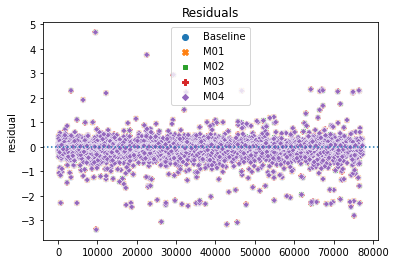

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.scatterplot(data=residuals.drop(columns='actual'))
plt.axhline(y=0, ls=':')
plt.ylabel('residual')
plt.title('Residuals')

In [32]:
#model01_prediction
lm = LinearRegression(normalize=True)
lm.fit(X_train, y_train.logerror)
   
y_test['model01_pred'] = lm.predict(X_test)
   
rmse_model01_test = (mean_squared_error(y_test.logerror, y_test['model01_pred']))**(1/2)

print(rmse_model01_test)

0.16322716640774126
